In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers

#url = "https://raw.githubusercontent.com/likarajo/petrol_consumption/master/data/petrol_consumption.csv"
df = pd.read_csv("survey lung cancer.csv")
df.head(4)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO


C:\Users\Иван\AppData\Local\Temp\ipykernel_18028\4219555724.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = df.corr()


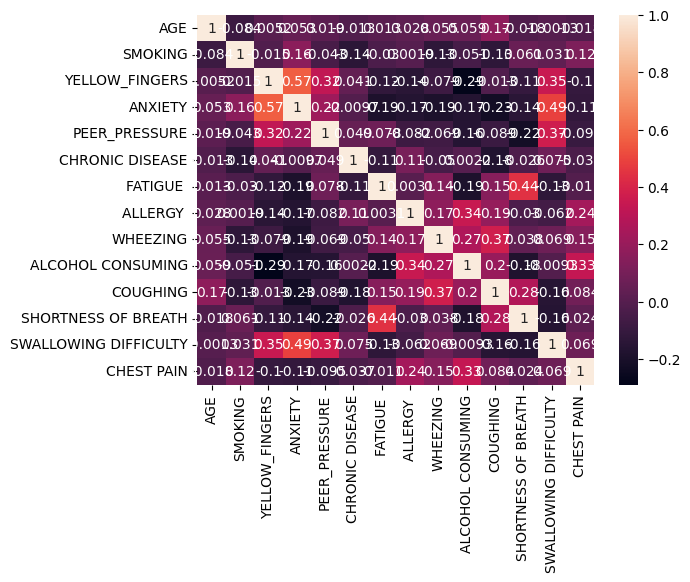

In [2]:
corrMatrix = df.corr()
plot = sns.heatmap(corrMatrix,annot=True)
plot.get_figure().savefig("eban.png")

In [3]:
dataset = df.drop('Average_income',1)
dataset.head()

C:\Users\Иван\AppData\Local\Temp\ipykernel_17500\2175866439.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = df.drop('Average_income',1)


,Petrol_tax,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,1976,0.525,541
1,9.0,1250,0.572,524
2,9.0,1586,0.580,561
3,7.5,2351,0.529,414
4,8.0,431,0.544,410


In [4]:
import numpy as np
dataset = np.log(dataset)
dataset.head()

,Petrol_tax,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,2.197225,7.588830,-0.644357,6.293419
1,2.197225,7.130899,-0.558616,6.261492
2,2.197225,7.368970,-0.544727,6.329721
3,2.014903,7.762596,-0.636767,6.025866
4,2.079442,6.066108,-0.608806,6.016157


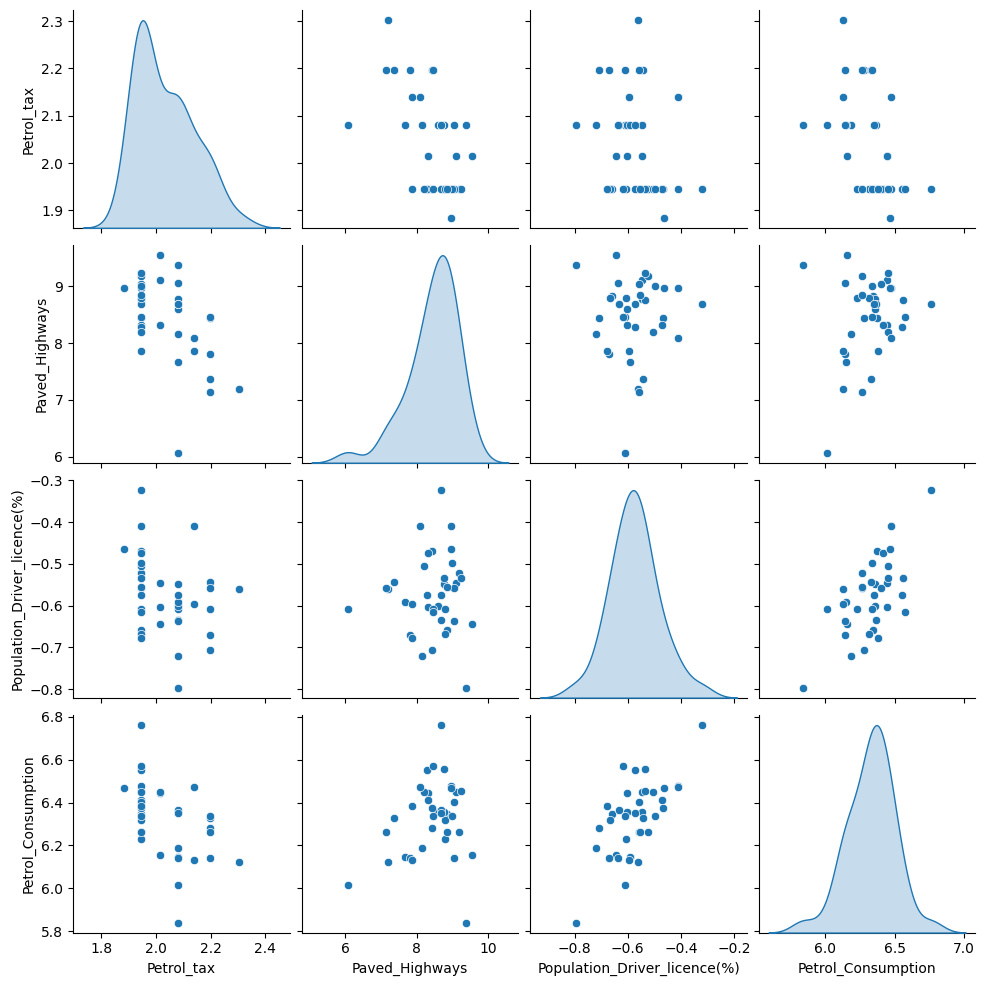

In [5]:
train_data = dataset.sample(frac=0.8,random_state=0)
test_data = dataset.drop(train_data.index)
sns.pairplot(train_data[['Petrol_tax','Paved_Highways','Population_Driver_licence(%)','Petrol_Consumption']],diag_kind="kde")

In [6]:
train_stats = test_data.describe()
train_stats.pop("Petrol_Consumption")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Petrol_tax,10.0,2.011910,0.195272,1.609438,1.945910,2.047172,2.182935,2.197225
Paved_Highways,10.0,8.203077,0.917454,6.400257,7.746799,8.274728,8.638969,9.785942
Population_Driver_licence(%),10.0,-0.535715,0.106849,-0.659712,-0.626127,-0.564764,-0.424997,-0.390084


In [7]:
train_labels = train_data.pop("Petrol_Consumption")
test_labels = test_data.pop("Petrol_Consumption")

In [8]:
def norm(x):
    return (x-train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_data)
normed_test_data = norm(test_data)
normed_train_data.head()

,Petrol_tax,Paved_Highways,Population_Driver_licence(%)
29,0.949007,0.263278,-1.605361
4,0.345832,-2.329238,-0.684062
26,0.345832,0.426061,-0.615497
30,-0.337991,0.694229,-1.142409
32,0.345832,0.632365,-0.116676


In [9]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64,activation='sigmoid',input_shape=[len(train_data.keys())]),
        layers.Dense(64,activation='sigmoid'),
        layers.Dense(128,activation='tanh'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae','mse']
    )
    return model
model = build_model()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________


In [11]:
example_batch = normed_test_data[:30]
example_res = model.predict(example_batch)
example_res

1/1 [==============================] - 0s 231ms/step


array([[0.11390524],
       [0.11747688],
       [0.10602093],
       [0.1189469 ],
       [0.14337851],
       [0.10155141],
       [0.10897562],
       [0.1301338 ],
       [0.14123888],
       [0.11103816]], dtype=float32)

In [12]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100==0:
            print(".",end='')

EPOCHS =500

history = model.fit(
    normed_train_data,train_labels,
    epochs=EPOCHS,validation_split=0.2,verbose=0,
    callbacks=[PrintDot()]
)

C:\Users\Иван\PycharmProjects\ai_test\venv\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


.....

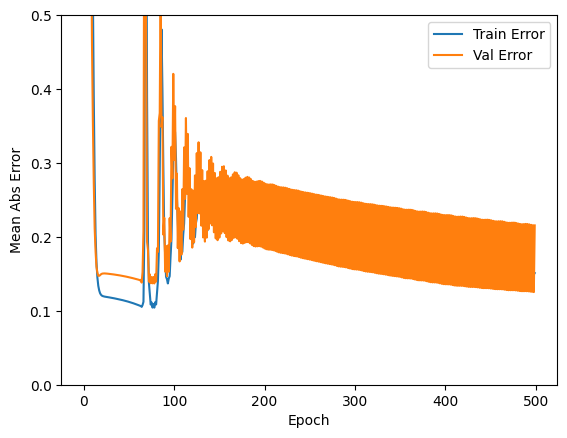

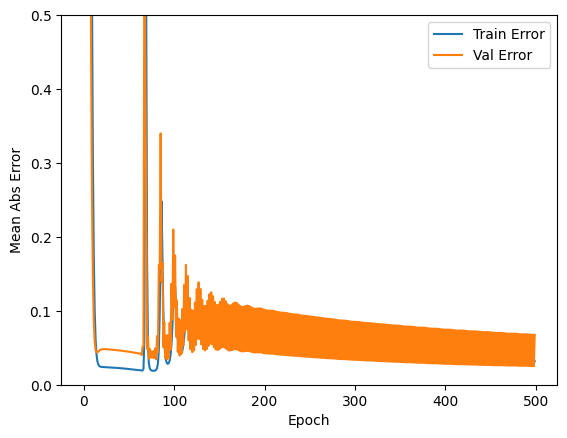

In [13]:
def print_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'],hist['mae'],label="Train Error")
    plt.plot(hist['epoch'],hist['val_mae'],label = "Val Error")
    plt.ylim([0,0.5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'],hist['mse'],label="Train Error")
    plt.plot(hist['epoch'],hist['val_mse'],label = "Val Error")
    plt.ylim([0,0.5])
    plt.legend()
    plt.show()
    
print_history(history)

C:\Users\Иван\PycharmProjects\ai_test\venv\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


.

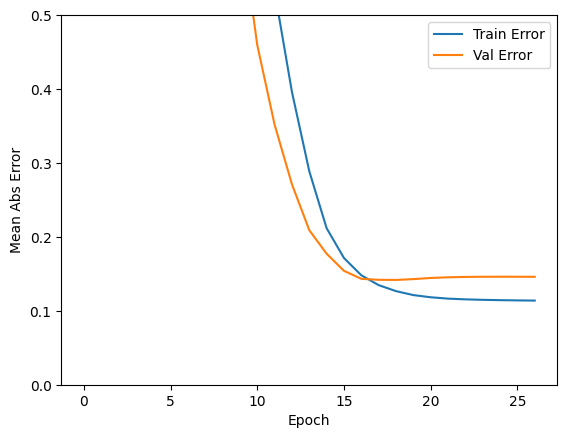

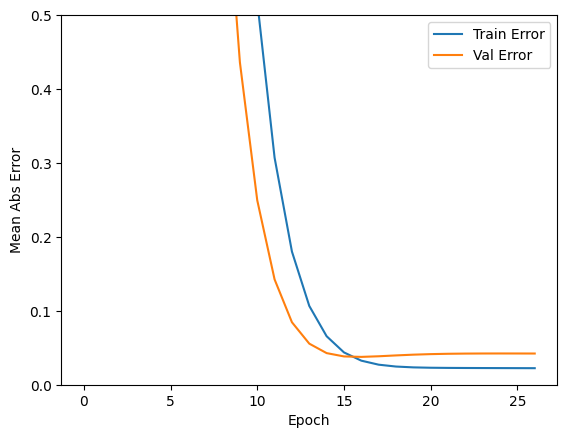

In [14]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

history = model.fit(normed_train_data,train_labels,epochs=EPOCHS,validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])

print_history(history)

In [15]:
loss,mae,mse = model.evaluate(normed_test_data,test_labels,verbose=2)
print("testing set Mean abs Error: {:5.2f}".format(mae))

1/1 - 0s - loss: 0.0525 - mae: 0.1677 - mse: 0.0525 - 19ms/epoch - 19ms/step
testing set Mean abs Error:  0.17


1/1 [==============================] - 0s 64ms/step


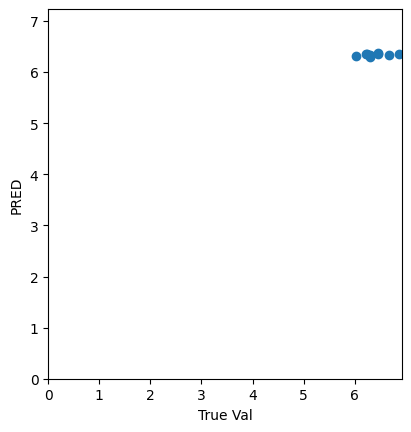

In [16]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels,test_pred)
plt.xlabel('True Val')
plt.ylabel('PRED')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])

_ = plt.plot([-20,-20],[-20,20])

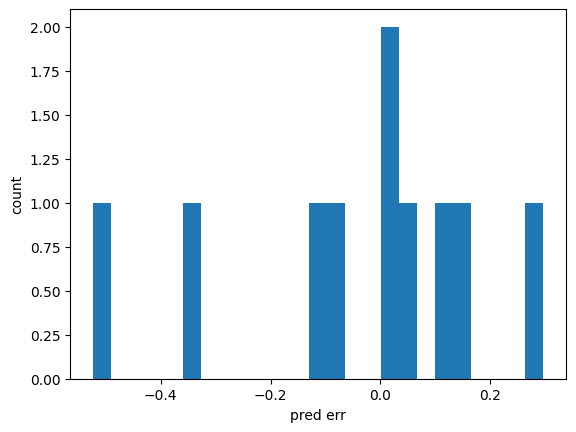

In [17]:
error = test_pred - test_labels

plt.hist(error,bins=25)
plt.xlabel("pred err")

_ = plt.ylabel("count")